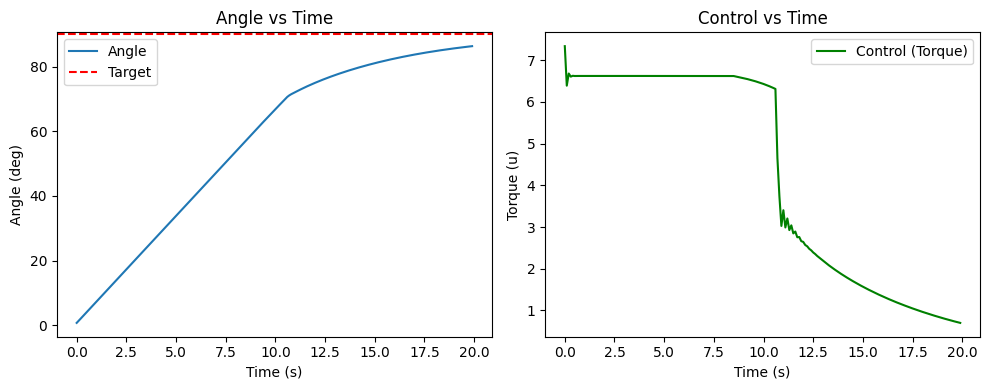

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Triangular Membership Function ----------
def trimf(x, a, b, c):
    if x <= a or x >= c:
        return 0.0
    elif x == b:
        return 1.0
    elif x < b:
        return (x - a) / (b - a)
    else:
        return (c - x) / (c - b)

# ---------- Input Fuzzy Sets: Error (e) ----------
def err_neg(x): return trimf(x, -100, -100, 0)     # Arm far below target
def err_zero(x): return trimf(x, -20, 0, 20)       # Arm near target
def err_pos(x): return trimf(x, 0, 100, 100)       # Arm far above target

# ---------- Input Fuzzy Sets: Derivative of Error (de) ----------
def derr_neg(x): return trimf(x, -50, -50, 0)      # Error decreasing fast
def derr_zero(x): return trimf(x, -10, 0, 10)      # Error stable
def derr_pos(x): return trimf(x, 0, 50, 50)        # Error increasing fast

# ---------- Output Fuzzy Sets: Control (Torque, u) ----------
u_universe = np.linspace(-20, 20, 401)             # Output range (torque levels)

def u_sn(x): return trimf(x, -20, -20, -10)        # Strong negative torque
def u_wn(x): return trimf(x, -15, -7, 0)           # Weak negative torque
def u_z(x):  return trimf(x, -3, 0, 3)             # Zero torque
def u_wp(x): return trimf(x, 0, 7, 15)             # Weak positive torque
def u_sp(x): return trimf(x, 10, 20, 20)           # Strong positive torque

# ---------- Rule Base (Mamdani) ----------
def evaluate_rules(e_val, de_val):
    e_neg = err_neg(e_val); e_zero = err_zero(e_val); e_pos = err_pos(e_val)
    de_neg = derr_neg(de_val); de_zero = derr_zero(de_val); de_pos = derr_pos(de_val)

    fired = []
    # Rule table (9 total)
    fired.append((min(e_neg, de_neg), u_sn))  # if e is neg and de is neg → strong neg torque
    fired.append((min(e_neg, de_zero), u_wn))
    fired.append((min(e_neg, de_pos), u_z))

    fired.append((min(e_zero, de_neg), u_wn))
    fired.append((min(e_zero, de_zero), u_z))
    fired.append((min(e_zero, de_pos), u_wp))

    fired.append((min(e_pos, de_neg), u_z))
    fired.append((min(e_pos, de_zero), u_wp))
    fired.append((min(e_pos, de_pos), u_sp))
    return fired

# ---------- Aggregation ----------
def aggregate(fired, u_univ):
    agg = np.zeros_like(u_univ)
    for strength, mf_func in fired:
        if strength <= 0:
            continue
        vals = np.array([min(strength, mf_func(u)) for u in u_univ])
        agg = np.maximum(agg, vals)
    return agg

# ---------- Defuzzification (Centroid) ----------
def defuzz_centroid(combined_mf, u_univ):
    num = np.sum(combined_mf * u_univ)
    den = np.sum(combined_mf)
    if den == 0:
        return 0.0
    return num / den

# ---------- Simulation Parameters ----------
target_angle = 90.0       # degrees (desired position)
cur_angle = 0.0            # starting angle
dt = 0.1                   # time step (s)
gain = 1.0                 # effect of torque on angle
max_steps = 200
control_sat = 20.0         # torque limit

# ---------- Simulation Loop ----------
time_hist, angle_hist, control_hist = [], [], []
prev_error = target_angle - cur_angle

for step in range(max_steps):
    e = target_angle - cur_angle
    de = (e - prev_error) / dt

    # Fuzzy inference
    fired = evaluate_rules(e, de)
    agg = aggregate(fired, u_universe)
    u_out = defuzz_centroid(agg, u_universe)

    # Saturation
    u_out = max(min(u_out, control_sat), -control_sat)

    # Update angle (simple model)
    cur_angle += gain * u_out * dt

    time_hist.append(step * dt)
    angle_hist.append(cur_angle)
    control_hist.append(u_out)

    prev_error = e

    # Stop if close to target
    if abs(e) < 0.5 and abs(de) < 0.2:
        print(f"✅ Converged at step {step}, angle = {cur_angle:.2f}")
        break

# ---------- Plot Results ----------
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(time_hist, angle_hist, label='Angle')
plt.axhline(target_angle, color='r', linestyle='--', label='Target')
plt.xlabel('Time (s)')
plt.ylabel('Angle (deg)')
plt.title('Angle vs Time')
plt.legend()

plt.subplot(1,2,2)
plt.plot(time_hist, control_hist, color='g', label='Control (Torque)')
plt.xlabel('Time (s)')
plt.ylabel('Torque (u)')
plt.title('Control vs Time')
plt.legend()

plt.tight_layout()
plt.show()
